In [ ]:

import pandas as pd
import numpy as np
from faker import Faker
import random
from synthesis.synthesizers.privbayes import PrivBayes
from sklearn.preprocessing import LabelEncoder
from Metrics import All_synthcity
from Metrics import AttributeInference1 as AIR
from Metrics import CGeneralizedCAP as GCAP
from Metrics import CZeroCAP as CZCAP
from Metrics import NNAA
from Metrics import MemInf as MIR
from Metrics import Hitting_rate
from Metrics import MDCR
from Metrics import DCR
from Metrics import NNDR
from Metrics import Hidden_rate
from DataSynthesizer1.DataDescriber import DataDescriber
from DataSynthesizer1.DataGenerator import DataGenerator
from datetime import datetime
import os

In [ ]:
#Real dataset generation definition

def generate_real_data(num_samples):
    name_gen = Faker()
    heights = np.around(list(np.random.normal(loc=170, scale=10, size=num_samples)), 2)
    classic_icecreams = [
        "Vanilla", "Chocolate", "Strawberry", "Mint Chocolate Chip",
        "Cookies and Cream", "Rocky Road", "Butter Pecan", "Neapolitan",
        "Pistachio", "French Vanilla"
    ]
    fav_icecream = list(random.choices(classic_icecreams, k=num_samples))

    # Generate random first and last names
    name_df = pd.DataFrame({
        'First Name': [name_gen.first_name() for _ in range(num_samples)],
        'Last Name': [name_gen.last_name() for _ in range(num_samples)]
    })
    height_df = pd.DataFrame({'Height': heights})
    icecream_df = pd.DataFrame({'Flavour': fav_icecream})
    basic_df = pd.concat([name_df, height_df, icecream_df], axis=1)
    
    # Set random seed for reproducibility
    random.seed(42)
    np.random.seed(42)

    # Define country list and correlation rules
    countries = ["USA", "Canada", "Germany", "France", "Italy", "China", "Brazil", "Australia", "Japan", "UK", "Sweden", "Norway", "Denmark", "Finland"]

    # Ice cream preferences (default: random choice)
    ice_creams = ["Vanilla", "Chocolate", "Strawberry", "Mint", "Pistachio", "Stracciatella"]

    # Generate data
    data = []
    for i in range(num_samples):
        person = {}

        # Assign country
        person["Country of Origin"] = random.choice(countries)

        # Assign favorite ice cream with correlation (Italy → Stracciatella preference)
        if person["Country of Origin"] == "Italy":
            person["Favorite Icecream"] = np.random.choice(ice_creams, p=[0.1, 0.1, 0.1, 0.1, 0.2, 0.4])
        else:
            person["Favorite Icecream"] = random.choice(ice_creams)

        # Assign liking for liquorice (Nordic countries → Higher probability)
        if person["Country of Origin"] in ["Sweden", "Norway", "Denmark", "Finland"]:
            person["Like Liquorice"] = np.random.choice([1, 0], p=[0.9, 0.1])  # 70% chance for Nordic countries
        else:
            person["Like Liquorice"] = np.random.choice([1, 0], p=[0.2, 0.8])  # 20% for others

        # Assign number of times visited Italy (Random integer, but higher if from Europe)
        if person["Country of Origin"] in ["Germany", "France", "UK", "Sweden", "Norway", "Denmark", "Finland", "Italy"]:
            person["Times Visited Italy"] = np.random.poisson(2)  # Higher average visits
        else:
            person["Times Visited Italy"] = np.random.poisson(0.5)  # Lower average visits

        # First time in London (UK residents more likely to say yes)
        person["First Time London"] = 1 if person["Country of Origin"] == "UK" else np.random.choice([1, 0], p=[0.2, 0.8])

        # Number of steps per day (Normal distribution with realistic values)
        person["Steps per Day"] = max(1000, int(np.random.normal(8000, 3000)))  # Avoids negative steps

        data.append(person)

    # Create DataFrame
    df = pd.DataFrame(data)
    
    full_df = pd.concat([basic_df, df], axis=1)
    
    return full_df

num_samples = 1500

real_data = generate_real_data(num_samples)

In [ ]:
#Synthesize dataset with 2 different methods
def synthesize_no_bin(real_data, eps):    
    # instantiate and fit synthesizer
    pb = PrivBayes(epsilon=eps, verbose=False)
    pb.fit(real_data)

    # Synthesize data
    gen_data  = pb.sample()

    # Save to csv file
    result = pd.DataFrame(gen_data.values, columns=gen_data.columns, index=range(real_data.shape[0]))
    
    return result

def synthesize_bin(real_data, eps):
    real_data['Height'] = real_data['Height'].astype(float)
    fn_encoder = LabelEncoder()
    ln_encoder = LabelEncoder()
    fl_encoder = LabelEncoder()
    na_encoder = LabelEncoder()
    r_fn = fn_encoder.fit_transform(real_data['First Name'])
    r_ln = ln_encoder.fit_transform(real_data['Last Name'])
    r_na = na_encoder.fit_transform(real_data['Nationality'])
    r_fl = fl_encoder.fit_transform(real_data['Favorite Icecream'])
    all_labels = pd.DataFrame({'First Name':r_fn, 'Last Name': r_ln, 'Height': real_data['Height'],'Nationality': r_na, 'Favorite Icecream':r_fl, 'Like Liquorice': real_data['Like Liquorice'], 'Times Been to Italy': real_data['Times Been to Italy'], 'First Time London': real_data['First Time London'], 'Steps per Day': real_data['Steps per Day']})
    
    describer = DataDescriber()
    timestamp = datetime.now().timestamp()
    all_labels.to_csv(f'{timestamp}.csv', index=False)
    describer.describe_dataset_in_correlated_attribute_mode(dataset_file=f'{timestamp}.csv', 
                                                            epsilon=eps, 
                                                            k=2,
                                                            attribute_to_is_candidate_key={"First Name": False, "Last Name": False, "Height": False, "Nationality": False, "Favorite Icecream": False, "Like Liquorice": False, "Times Been to Italy": False, "First Time London": False, "Steps per Day": False},
                                                            attribute_to_datatype={"First_Name": "Integer", "Last_Name": "Integer", "Height": "Float", "Nationality": "Integer","Favorite Icecream": "Integer","Like Liquorice": "Integer","Times Been to Italy": "Integer", "First Time London": "Integer","Steps per Day": "Integer"},
                                                            attribute_to_is_categorical={'First_Name': True, 'Last_Name': True, 'Height': False, "Nationality": True, "Favorite Icecream": True,"Like Liquorice": True,"Times Been to Italy": True, "First Time London": True,"Steps per Day": False},
                                                            )
    description = f'{timestamp}.json'
    syn_path = f'syn_{timestamp}.csv'
    describer.save_dataset_description_to_file(description)
    generator = DataGenerator()
    generator.generate_dataset_in_correlated_attribute_mode(n=len(all_labels), description_file=description, seed=timestamp)
    generator.save_synthetic_data(syn_path)
    result = pd.read_csv(syn_path, index_col=False).round(2)
    os.remove(f'{timestamp}.csv')
    os.remove(f'{timestamp}.json')
    os.remove(f'syn_{timestamp}.csv')
    result['First Name'] = fn_encoder.inverse_transform(result['First Name'].astype(int))
    result['Last Name'] = ln_encoder.inverse_transform(result['Last Name'].astype(int))
    result['Nationality'] = na_encoder.inverse_transform(result['Nationality'].astype(int))
    result['Favorite Icecream'] = fl_encoder.inverse_transform(result['Favorite Icecream'].astype(int))
    return result

if __name__ == '__main__':
    eps_list = [0.02, 0.05, 0.1, 0.2, 0.5, 1, 2.5, 5]
    for eps in eps_list:
        synthesize_no_bin(real_data, eps).to_csv(f"demo_syn/syn_bin_{eps}.csv")
        synthesize_bin(real_data, eps).to_csv(f"demo_syn_new/syn_no_{eps}.csv", index=0)


In [ ]:
#Get metric results
def get_metric_results(real_data, syn_data):
    real_data['Height'].astype('Float32')
    syn_data['Height'].astype('Float32')

    all_data = pd.concat([real_data, syn_data])
    fn_encoder = LabelEncoder()
    ln_encoder = LabelEncoder()
    fl_encoder = LabelEncoder()
    na_encoder = LabelEncoder()
    r_fn = fn_encoder.fit_transform(all_data['First Name'])
    r_ln = ln_encoder.fit_transform(all_data['Last Name'])
    r_na = na_encoder.fit_transform(all_data['Nationality'])
    r_fl = fl_encoder.fit_transform(all_data['Favorite Icecream'])
    all_labels = pd.DataFrame({'First Name':r_fn, 'Last Name': r_ln, 'Height': all_data['Height'],'Nationality': r_na, 'Favorite Icecream':r_fl, 'Like Liquorice': all_data['Like Liquorice'], 'Times Been to Italy': all_data['Times Been to Italy'], 'First Time London': all_data['First Time London'], 'Steps per Day': all_data['Steps per Day']})
    real_labels = all_labels[:len(real_data)]
    syn_labels = all_labels[-len(real_data):]
    
    metrics = {
                    'sanity': ['common_rows_proportion', 'nearest_syn_neighbor_distance', 'close_values_probability', 'distant_values_probability'],
                    'stats': ['alpha_precision'],
                    'detection': ['detection_mlp'],
                    'privacy': ['identifiability_score'],
                }
    
    synthcity_results = All_synthcity.calculate_metric(args = None, _real_data=real_data, _synthetic=real_data, _metrics=metrics)
    crp = synthcity_results['mean'][1]
    nsnd = 1-synthcity_results['mean'][2]
    cvp = synthcity_results['mean'][3]
    dvp = 1-synthcity_results['mean'][4]
    auth = synthcity_results['mean'][10]
    mlp = synthcity_results['mean'][11]
    id_score = synthcity_results['mean'][12]
    air = AIR.calculate_metric(args = None, _real_data=real_data, _synthetic=syn_data)
    gcap = GCAP.calculate_metric(args = None, _real_data=real_labels, _synthetic=syn_labels)
    zcap = CZCAP.calculate_metric(args = None, _real_data=real_labels, _synthetic=syn_labels)
    mdcr = MDCR.calculate_metric(args=None, _real_data=real_labels, _synthetic=syn_labels)
    hitR = Hitting_rate.calculate_metric(args=None, _real_data=real_labels, _synthetic=syn_labels)
    mir = MIR.calculate_metric(args=None, _real_data=real_labels, _synthetic=syn_labels)
    nnaa = NNAA.calculate_metric(args=None, _real_data=real_labels, _synthetic=syn_labels)
    dcr = DCR.calculate_metric(args=None, _real_data=real_labels, _synthetic=syn_labels)
    nndr = NNDR.calculate_metric(args=None, _real_data=real_labels, _synthetic=syn_labels)
    hidd = Hidden_rate.calculate_metric(args=None, _real_data=real_labels, _synthetic=syn_labels)
     
    priv_results = np.around([air, gcap, zcap, 
                            mdcr, hitR, mir, 
                            nnaa, crp, nsnd, 
                            cvp, dvp, auth, 
                            mlp, id_score, 
                            dcr, nndr, hidd
                            ], 2).tolist()
    
    metric_list = ["Attribute Inference Risk", "GeneralizedCAP", "ZeroCAP", 
                   "Median Distance to Closest Record", "Hitting Rate",
                   "Membership Inference Risk", "Nearest Neighbour Adversarial Accuracy",
                   "Common Row Proportion", "Nearest Synthetic Neighbour Distance",
                   "Close Value Probability", "Distant Value Probability",
                   "Authenticity", "DetectionMLP", "Identifiability Score"
                   , "Distance to Closest Record", "Nearest Neighbour Distance Ratio", "Hidden Rate"
                   ]
    
    results = pd.DataFrame({'Metric':metric_list, 'Result':priv_results})
    
    return results

eps_list = [0.02, 0.05, 0.1, 0.2, 0.5, 1, 2.5, 5]

for eps in eps_list:
    syn_no = pd.read_csv(f"demo_syn/syn_no_{eps}.csv")
    syn_bin = pd.read_csv(f"demo_syn/syn_bin_{eps}.csv")
    get_metric_results(real_data, syn_no).to_csv(f"metric_results/syn_bin_{eps}.csv")
    get_metric_results(real_data, syn_bin).to_csv(f"metric_results/syn_no_{eps}.csv")

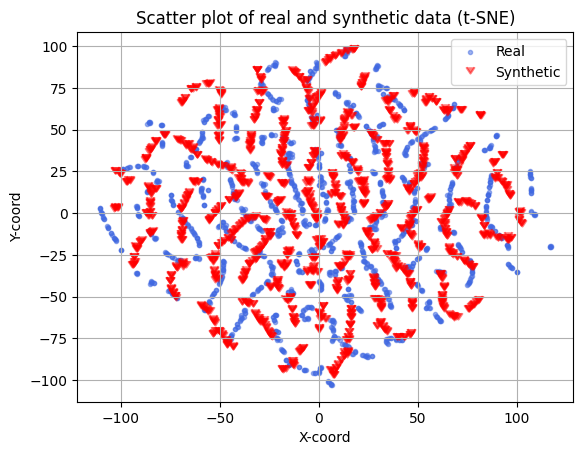

In [32]:
import pandas as pd
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

real_data = pd.read_csv(f'sample_data_1.csv', index_col=False)
syn = pd.read_csv(f'demo_syn/syn_no_1_5.csv', index_col=False).drop(columns=['Unnamed: 0'])

categorical_columns = ['First Name', 'Last Name', 'Nationality', 'Favorite Icecream']
real_encoded = pd.get_dummies(real_data, columns=categorical_columns)
syn_encoded = pd.get_dummies(syn, columns=categorical_columns)

tsne = TSNE(perplexity=4, n_components=2)
real_coords_tsne = tsne.fit_transform(real_encoded)
syn_coords_tsne = tsne.fit_transform(syn_encoded)

def scatter_plot_tsne(coord_real, coord_synth):
    real = pd.DataFrame(coord_real)
    syn = pd.DataFrame(coord_synth)
    # Scatter Plot
    plt.figure()

    # Plot DataFrame 1
    plt.scatter(real[0], real[1], marker='.', color='royalblue', label='Real', alpha=0.5)

    # Plot DataFrame 2
    plt.scatter(syn[0], syn[1], marker=7,color='red', label='Synthetic', alpha=0.5)
    

    plt.title('Scatter plot of real and synthetic data (t-SNE)')
    plt.xlabel('X-coord')
    plt.ylabel('Y-coord')
    plt.legend()
    plt.grid(True)
    plt.show()

    return 

scatter_plot_tsne(real_coords_tsne, syn_coords_tsne)

## Get Metric Results for Tabsyn

Here is the code used to get the metric results for the SDG mechanism [Tabsyn](https://doi.org/10.48550/arXiv.2310.09656), using their provided dataset, namely, the [Shoppers]{https://www.kaggle.com/datasets/henrysue/online-shoppers-intention} dataset.

In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.manifold import TSNE
from get_metric_results import get_metric_results

df = pd.read_csv("Data/real.csv", index_col=False)
syn_df = pd.read_csv("Data/tabsyn.csv", index_col=False)

all_data = pd.concat([df, syn_df], ignore_index=True)

cat_cols = all_data.select_dtypes(include=['object', 'bool']).columns

# Initialize a dictionary to hold encoded data
encoded_data = {}
for col in cat_cols:
    if all_data[col].dtype == 'bool':
        encoded_data[col] = all_data[col].astype(int)
    else:
        le = LabelEncoder()
        encoded_data[col] = le.fit_transform(all_data[col].astype(str))

num_cols = all_data.select_dtypes(exclude=['object', 'bool']).columns
for col in num_cols:
    encoded_data[col] = all_data[col]

all_labels = pd.DataFrame(encoded_data)
real_len = len(df)
real_labels = all_labels[:real_len]
syn_labels = all_labels[real_len:]

tsne = TSNE(n_components=2)
real_coords_tsne = tsne.fit_transform(real_labels)
syn_coords_tsne = tsne.fit_transform(syn_labels)

tsne_df_real = pd.DataFrame(real_coords_tsne)
tsne_df_syn = pd.DataFrame(syn_coords_tsne)

metric_results = get_metric_results(df, syn_df, real_labels, syn_labels, sensitive_attributes=['Revenue'])
print("Metric Results:")
print(metric_results)

metric_results.to_csv("metric_results/tabsyn_metric_results.csv", index=False)
